# Transformer comparison *HSTU* to *SASRec*
This guide tells about *Hierarchical Sequential Transduction Unit* *(HSTU)* - self-attention mechanism proposed in paper [Actions Speak Louder than Words: Trillion-Parameter Sequential Transducers
for Generative Recommendations](https://arxiv.org/abs/2402.17152). Also we show RecTools implementation metrics results on datasets movielens-1m and movielens-20m preprocessed by authors of the paper and preprocessed by RecTools framework

### Table of Contents

*  Review of HSTU
*  Reproduce RecTools implementation in fully original paper setup
*  Variation relative positional and time attentions
*  Time context implementation details 
  


### Review of *HSTU*

*HSTU* - is self-attention mechanism challenging recommendation systems problems. We make short overview.


<div style="text-align:center">
    <img src="src/hstu_overview.png" alt="Описание" width="30%">
</div>

 In a simple case, by a unified sequence, we will simply mean a sequence of user interactions, even without interleaving with actions. In this setup paper metrics are shown. Paper training objective setup is shifted sequence, but also proposed approach emitting several training examples at the end of sequence for industrial scale setup for reduce streaming fine-tune training time complexity

\begin{equation}
U(X), V(X), Q(X), K(X) = \text{Split}(\phi_1(f_1(X))) \tag{1}
\end{equation}

\begin{equation}
A(X)V(X) = \frac{\phi_2 \left( Q(X)K(X)^T + \text{rab}^{p,t} \right) V(X)}{N} \tag{2}
\end{equation}

\begin{equation}
Y(X) = f_2 \left( \text{Norm}(A(X)V(X)) \odot U(X) \right) \tag{3}
\end{equation}

where $ f_{i} $ is a linear mapping, $\phi$ is the SiLU function, and $\text{rab}^{p,t} $ is the sum of two attention matrices: relative positional attention  and relative time attention. The first important change is the use of elementwise SiLU instead of SoftMax. This approach allows for faster learning in a setting where the set of items is constantly changing. Moreover, the denominator of the softmax normalizes attention, capturing all the previous context of user interactions, and this is not always justified. SiLU changes the absolute value of token-to-token attention. The second change is the weighting of the classic self-attention output by the $U(X)$ matrix, which solves the DLRM problem of feature interaction.


$\text{rab}^{t}$ - relative time attention, the picture shows first stage matrice formation

<div style="text-align:center">
    <img src="src/time_attention.jpg" alt="Описание" width="40%">
</div>


\begin{equation}
    a_{i,j} = t_{i+1} - t_j
\end{equation}
\begin{equation}
\text{bucket}(a_{i,j}) = 
\left\lfloor 
\frac{\log(|a_{i,j}| \vee 1)}{0.301} 
\right\rfloor
\end{equation}

To predict the next item, we use the time of its appearance. This is a simulation of inference with  time aware setup. In the current formulation, this is a candidate generation model, and based on real interest, in addition to the user's history, we would also provide the start time of his session. In this case, the last token, or the last row in the attention matrix, will be conditioned on the start time of the user's session. In this way, the consistency of the model is maintained between training and testing (real-world inference).That is, all possible differences $a_{i,j}$ are quantized into buckets with logarithmic asymptotics. If the banquet values are greater than the specified $b_{max}$, then it is truncated to the maximum. Each bucket value corresponds to the learning parameter $w_{i}$, which is substituted instead of $a_{i,j}$. Thus, we form the matrix $\text{rab}^{t}$. Moreover, we note that the time quantization function and the maximum number of buckets are hyperparameters. We can vary them depending on the nature of the content.

Quantification of the timestamp difference actually breaks down the user's previous history into time microsessions relative to the current generation moment.



### RecTools implementation

Details of the implementation.
1) Has been written from jagged tensors to usual torch tensors
2) Has been droped original paper init distributions over all parameters where it possible, and replaced by xavier distribution
3) Left padding isntead of right for consistency to RecTools 
4) No Q,K caching option  

In [1]:
import os
import typing as tp
import warnings

import pandas as pd
import numpy as np
import torch
from lightning_fabric import seed_everything
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.loggers import CSVLogger
import pandas as pd
import ast
from pathlib import Path
from pytorch_lightning.callbacks import   Callback
from rectools.dataset import Dataset
from rectools.models import HSTUModel
from rectools.models.nn.item_net import IdEmbeddingsItemNet
from rectools import Columns
from scipy import sparse
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback
# Enable deterministic behaviour with CUDA >= 10.2
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
from rectools.model_selection.splitter import Splitter
from rectools.model_selection import LastNSplitter, TimeRangeSplitter
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
from rectools.metrics import (
    MAP,
    CoveredUsers,
    Intersection,
    Serendipity,
    NDCG,
    AvgRecPopularity,
    CatalogCoverage,
    Recall,
    SufficientReco,
)
from rectools.models import  SASRecModel
from rectools.model_selection import  cross_validate
from rectools.models.nn.item_net import IdEmbeddingsItemNet
import json
from utils import  RecallCallback, BestModelLoad, get_results

In [2]:
RANDOM_STATE=42
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)

Seed set to 42


42

### Movielens-1m  

First, we use ml-1m paper preprocessed dataset to show reproduce. But we also handle original ml-1m preprocessed by RecTools, because the first has no time kind stable sort when user sequence form. To download paper datasets see original repro of the paper   

In [4]:
%%time
!wget -q https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ml-1m.zip
!unzip -o ml-1m.zip
!rm ml-1m.zip

Archive:  ml-1m.zip
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
CPU times: user 15.8 ms, sys: 44.2 ms, total: 60 ms
Wall time: 2.37 s


In [5]:
def get_paper_df(dataset_name: str = "ml-1m") -> pd.DataFrame:
    path  = f"paper_{dataset_name}.csv"
    
    with warnings.catch_warnings():
        warnings.warn(f"You can download the dataset from the article using the link above and rename it to {path}", UserWarning)
        paper_df = pd.read_csv(path)
    paper_df = paper_df[["index","user_id", "sequence_item_ids", "sequence_ratings", "sequence_timestamps"]]
    cols_to_expand = ["sequence_item_ids", "sequence_ratings", "sequence_timestamps"]
    for col in cols_to_expand:
        paper_df[col] = paper_df[col].apply(ast.literal_eval)
    
    expanded_df = paper_df[["user_id"] + cols_to_expand]
    expanded_df = expanded_df.explode(cols_to_expand)
    expanded_df = (
        expanded_df
        .rename(columns={
            "sequence_item_ids": "item_id",
            "sequence_ratings": "rating",
            "sequence_timestamps": "timestamp"
        })
        .astype({
            "item_id": int,
            "rating": float,
            "timestamp": int
        })
    )
    expanded_df["datetime"] = pd.to_datetime(expanded_df["timestamp"], unit="s")
    expanded_df.drop(columns=["timestamp"], inplace= True)
    expanded_df.reset_index(drop=True, inplace=True)
    df = expanded_df[["user_id", "item_id", "datetime"]]
    df["weight"] = 1
    return df

In [6]:
def get_original_df(dataset_name: str = "ml-1m") -> pd.DataFrame:
    df = pd.read_csv(
        f"{dataset_name}/ratings.dat", 
        sep="::",
        engine="python",  # Because of 2-chars separators
        header=None,
        names=[Columns.User, Columns.Item, Columns.Weight, Columns.Datetime],
    )
    df[Columns.Datetime] = df[Columns.Datetime].astype("datetime64[s]")
    df[Columns.Weight] = 1
    return df

#### LOO validation, LOO test setup

In [7]:
loo_splitter = LastNSplitter(1,1)

### Validation fold

Models do not create validation fold during `fit` by default. However, there is a simple way to force it.

Let's assume that we want to use Leave-One-Out validation for specific set of users. To apply it we need to implement `get_val_mask_func` with required logic and pass it to model during initialization.

This function should receive interactions with standard RecTools columns and return a binary mask which identifies interactions that should not be used during model training. But instrad should be used for validation loss calculation. They will also be available for Lightning Callbacks to allow RecSys metrics computations.

*Please make sure you do not use `partial` while doing this. Partial functions cannot be by serialized using RecTools.*

In [8]:
def leave_one_out_mask_for_users(
    interactions: pd.DataFrame, val_users: tp.Optional[np.ndarray] = None
) -> np.ndarray:
    groups = interactions.groupby(Columns.User)
    time_order = (
        groups[Columns.Datetime]
        .rank(method="first", ascending=True)
        .astype(int)
    )
    n_interactions = groups.transform("size").astype(int)
    inv_ranks = n_interactions - time_order
    last_interact_mask  = inv_ranks == 0
    if  val_users is not None:
        return (interactions[Columns.User].isin(val_users)) & last_interact_mask
    return last_interact_mask

In [9]:
# Callback for calculating RecSys metrics
RECALL_K = 10
PATIENCE = 5
DIVERGENCE_TRESHOLD = 0.01
recall_callback = RecallCallback(k=RECALL_K, prog_bar=True)
# Checkpoints based on validation loss
max_recall_ckpt = ModelCheckpoint(
    monitor=f"recall@{RECALL_K}",   # or just pass "val_loss" here,
    mode="max",
    filename="best_recall",
)
early_stopping_recall = EarlyStopping(
    monitor=f"recall@{RECALL_K}",
    mode="max",
    patience=PATIENCE,
    divergence_threshold=DIVERGENCE_TRESHOLD,
)
best_model_load = BestModelLoad("best_recall")
callbacks = [recall_callback, max_recall_ckpt, best_model_load]

In [10]:
# Function to get custom trainer
def get_trainer() -> Trainer: 
    return Trainer(
        accelerator="gpu",
        devices=1,
        min_epochs=100, 
        max_epochs=100,
        deterministic=True,
        enable_model_summary=False,
        enable_progress_bar=True,
        callbacks=callbacks,
        logger = CSVLogger("test_logs"),  # We use CSV logging for this guide but there are many other options
    )

In [11]:
metrics_add = {}
metrics_recall ={}
metrics_ndcg = {}
k_base =  10
K = [10, 50,100,200]
K_RECS= max(K)
for k in K:
    metrics_recall.update({
            f"recall@{k}": Recall(k=k),
        })
    metrics_ndcg.update({
            f"ndcg@{k}": NDCG(k=k, divide_by_achievable=True),
        })
metrics_add = {
    f"arp@{k_base}": AvgRecPopularity(k=k_base, normalize=True),
    f"coverage@{k_base}": CatalogCoverage(k=k_base, normalize=True),
    f"covered_users@{k_base}": CoveredUsers(k=k_base),
    f"sufficient_reco@{k_base}": SufficientReco(k=k_base),
    f"serendipity@{k_base}": Serendipity(k=k_base),
}
metrics  = metrics_recall | metrics_ndcg | metrics_add
metrics_to_show = ['recall@10', 'ndcg@10', 'recall@50', 'ndcg@50', 'recall@200', 'ndcg@200', 'coverage@10',
                       'serendipity@10']

In [12]:
def evaluate(models: dict, splitter:Splitter,dataset: Dataset, path_to_save_res:str) -> None:
    cv_results = cross_validate(
        dataset=dataset,
        splitter=splitter,
        models=models,
        metrics=metrics,
        k=K_RECS,
        filter_viewed=True,
    )
    cv_results["models_log_dir"] = {}
    for model_name, model in models.items():
        cv_results["models_log_dir"].update({model_name:model.fit_trainer.log_dir})
    with open(path_to_save_res, 'w', encoding='utf-8') as f:
        json.dump(cv_results, f, ensure_ascii=False, indent=4)

### Paper config

In [13]:
config = {
    "session_max_len": 200,
    "lightning_module_kwargs": {"logits_t": 0.05}, # logits scale factor
    "item_net_block_types": (IdEmbeddingsItemNet,),
    "get_val_mask_func": leave_one_out_mask_for_users,
    "get_trainer_func": get_trainer,
    "verbose": 1,
    "loss": 'sampled_softmax',
    "n_negatives": 128,
    "use_pos_emb": True,
    "dropout_rate": 0.2,
    "n_factors": 50, # embedding dim
    "n_heads": 1,
    "n_blocks": 2,
    "lr": 0.001,
    "batch_size": 128,
}
config_large = config.copy()
config_large["n_blocks"] = 8
config_large["n_heads"] = 2

### RecTools reproduce

In [14]:
dataset_name = "ml-1m"
path_to_save_res = f"beta_stable_cosine_test_paper_{dataset_name}.json"

In [15]:
hstu  = HSTUModel(    
    relative_time_attention=True,
    relative_pos_attention=True,
    **config
)
hstu_large  = HSTUModel(    
    relative_time_attention=True,
    relative_pos_attention=True,
    **config_large
)
models = {
    "hstu": hstu,
    "hstu_large": hstu_large,
}

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
paper_df = get_paper_df(dataset_name)
dataset_paper = Dataset.construct(paper_df)
evaluate(models,loo_splitter,dataset_paper,path_to_save_res)

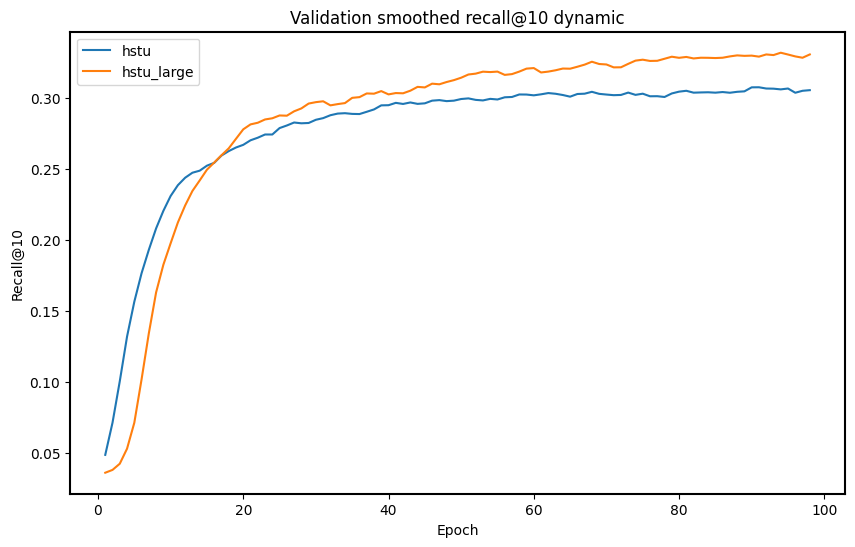

,recall@10,ndcg@10,recall@50,ndcg@50,recall@200,ndcg@200,coverage@10,serendipity@10
model,,,,,,,,
hstu,0.307718,0.172418,0.581815,0.232952,0.782875,0.263622,0.627700,0.002674
hstu_large,0.335045,0.189121,0.597714,0.247423,0.794965,0.277541,0.659017,0.002914


In [17]:
pivot_table = get_results(path_to_save_res,metrics_to_show, show_loss=False)
pivot_table

#### Comparison

| Method              | HR@10  | NDCG@10 | HR@50  | NDCG@50 | HR@200 | NDCG@200 |
|---------------------|--------|---------|--------|---------|--------|----------|
| HSTU paper          | 0.3097 | 0.1720  | 0.5754 | 0.2307  | 0.7716 | 0.2606   |
| HSTU RecTools       | 0.3076 | 0.1724  | 0.5818 | 0.2330  | 0.7825 | 0.2636   |
| HSTU-large paper    | 0.3294 | 0.1893  | 0.5935 | 0.2481  | 0.7839 | 0.2771   |
| HSTU-large RecTools | 0.3349 | 0.1891  | 0.5977 | 0.2474  | 0.7948 | 0.2775   |

In [18]:
path_to_save_res = f"pivot_results_RecTools_{dataset_name}.json"

In [ ]:
hstu  = HSTUModel(    
    relative_time_attention=True,
    relative_pos_attention=True,
    **config
)
hstu_rab_p  = HSTUModel(    
    relative_time_attention=False,
    relative_pos_attention=True,
    **config
)
hstu_rab_t  = HSTUModel(    
    relative_time_attention=True,
    relative_pos_attention=False,
    **config
)
hstu_no_rab  = HSTUModel(    
    relative_time_attention=False,
    relative_pos_attention=False,
    **config
)
sasrec = SASRecModel(
    **config
)
models = {
    "hstu_rab_t": hstu_rab_t,
    "hstu_rab_p": hstu_rab_p,
    "hstu": hstu,
    "hstu_no_rab": hstu_no_rab,
    "sasrec": sasrec,
}

original_df = get_original_df("ml-1m")
dataset_original = Dataset.construct(original_df)
evaluate(models,loo_splitter,dataset_original,path_to_save_res)

In [28]:
original_df = get_original_df("ml-1m")
dataset_original = Dataset.construct(original_df)

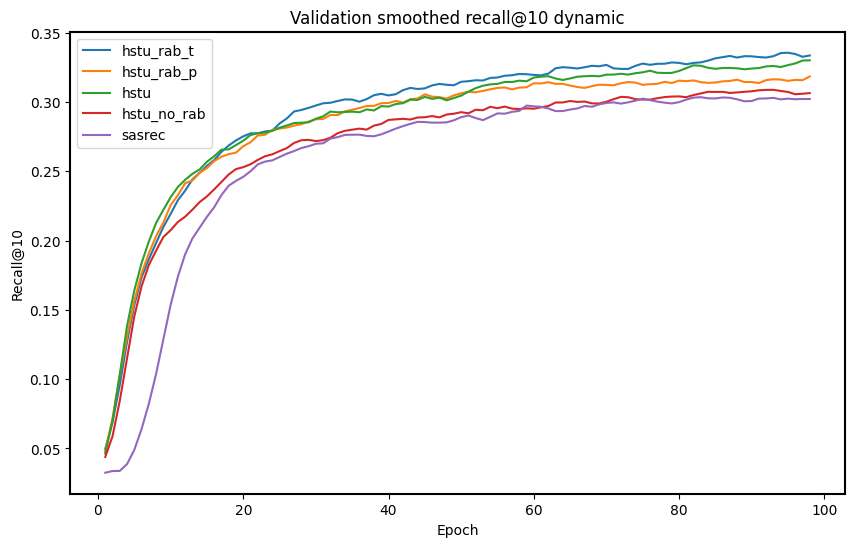

,recall@10,ndcg@10,recall@50,ndcg@50,recall@200,ndcg@200,coverage@10,serendipity@10
model,,,,,,,,
hstu_rab_t,0.329911,0.188306,0.593574,0.246846,0.785194,0.276039,0.633099,0.002896
hstu_rab_p,0.307055,0.176241,0.572541,0.234911,0.771779,0.265265,0.649838,0.002715
hstu,0.318483,0.183161,0.587115,0.242759,0.785194,0.272947,0.652808,0.002838
hstu_no_rab,0.299603,0.168478,0.563100,0.226745,0.768135,0.257997,0.628240,0.002583
sasrec,0.282544,0.160190,0.548029,0.218996,0.763167,0.251699,0.663067,0.002530


In [20]:
pivot_table = get_results(path_to_save_res,metrics_to_show, show_loss=False)
pivot_table

### Details recommend with context

If you use relative_time_attention it's required to pass current generation moment for users to correct recommend 

In [42]:
import rectools.dataset.context as context_prep
users = [1,2,3]
mask_for_last_interact = leave_one_out_mask_for_users(original_df, users)
original_df[mask_for_last_interact]

,user_id,item_id,weight,datetime
25,1,48,1,2001-01-06 23:39:11
136,2,1917,1,2000-12-31 22:02:54
232,3,2081,1,2000-12-31 21:35:04


In [47]:
context_df = pd.DataFrame(
    {
        Columns.User: [1, 2, 3],
        Columns.Datetime: ["2021-01-07 14:00:00", # for example
                           "2001-1-1", 
                           "2000-12-31 22:00:01"],
    }
)

In [48]:
hstu.recommend(
    users =users,
    dataset= dataset_original,
    k =3, 
    filter_viewed=True, 
    context=context_prep.get_context(context_df))

,user_id,item_id,score,rank
0,1,34,0.245521,1
1,1,364,0.243535,2
2,1,3751,0.229246,3
3,2,1,0.291973,1
4,2,1617,0.262810,2
5,2,296,0.252431,3
6,3,1,0.313745,1
7,3,2804,0.301430,2
8,3,3253,0.280423,3


if you want to call recommend, you have to pass context depends on model needed. Check it just below 

In [49]:
hstu.require_recommend_context, hstu_rab_p.require_recommend_context

(True, False)

In [50]:
hstu.recommend(
    users =users,
    dataset= dataset_original,
    k =3, 
    filter_viewed=True, 
    context=None)

ValueError: Mismatch between require_recommend_context (True) and context presence (False). Context must be provided only if require_recommend_context is True.

In [51]:
hstu_rab_p.recommend(
    users =users,
    dataset= dataset_original,
    k =3, 
    filter_viewed=True, 
    context=context_prep.get_context(context_df))

ValueError: Mismatch between require_recommend_context (False) and context presence (True). Context must be provided only if require_recommend_context is True.

### Movielens-20m